In [1]:
import torch
import scvi
import pandas as pd
import scanpy as sc
import scgen
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import FeatureAblation

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:2: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion
Global seed set to 0
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/captum/attr/_utils/visualization.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 pynndescent==0.5.7


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


### load model and data

In [2]:
base_path = '/home/icb/yuge.ji/projects/feature-attribution-sc'
adata = sc.read(f'{base_path}/datasets/scgen_norman19.h5ad')
adata

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/guide_identity' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/guide_identity' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/read_count' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/obsm' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/obsm/X_pca' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/obsm/X_umap' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/obsp' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/uns' wa

AnnData object with n_obs × n_vars = 69570 × 19018
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'g

In [3]:
file = 'scgen_norman19_model1_shuffled'
model = scgen.SCGEN.load(f'{base_path}/models/{file}', adata=adata)
model

INFO     File /home/icb/yuge.ji/projects/feature-attribution-sc/models/scgen_norman19_model1_
         shuffled/model.pt already downloaded                                                


SCGEN Model with the following params: 
n_hidden: 800, n_latent: 100, n_layers: 2, dropout_rate: 0.2
Training status: Trained

get perturbation names that match the labels (integers in the model): TODO

In [27]:
from scvi import REGISTRY_KEYS
pert_names = model.adata_manager.get_state_registry(REGISTRY_KEYS.BATCH_KEY)['categorical_mapping']
pert_names

array(['AHR', 'ARID1A', 'ARRDC3', 'ATL1', 'BAK1', 'BCL2L11', 'BCORL1',
       'BPGM', 'C3orf72', 'C19orf26', 'CBFA2T3', 'CBL', 'CDKN1A',
       'CDKN1B', 'CDKN1C', 'CEBPA', 'CEBPB', 'CEBPE', 'CELF2', 'CITED1',
       'CKS1B', 'CLDN6', 'CNN1', 'CNNM4', 'COL1A1', 'COL2A1', 'CSRNP1',
       'DLX2', 'DUSP9', 'EGR1', 'ELMSAN1', 'ETS2', 'FEV', 'FOSB', 'FOXA1',
       'FOXA3', 'FOXF1', 'FOXL2', 'FOXO4', 'GLB1L2', 'HES7', 'HK2',
       'HNF4A', 'HOXA13', 'HOXB9', 'HOXC13', 'IER5L', 'IGDCC3', 'IKZF3',
       'IRF1', 'ISL2', 'JUN', 'KIAA1804', 'KIF2C', 'KIF18B', 'KLF1',
       'KMT2A', 'LHX1', 'LYL1', 'MAML2', 'MAP2K3', 'MAP2K6', 'MAP4K3',
       'MAP4K5', 'MAP7D1', 'MAPK1', 'MEIS1', 'MIDN', 'NCL', 'NIT1',
       'OSR2', 'PLK4', 'POU3F2', 'PRDM1', 'PRTG', 'PTPN1', 'PTPN9',
       'PTPN12', 'PTPN13', 'RHOXF2', 'RREB1', 'RUNX1T1', 'S1PR2', 'SAMD1',
       'SET', 'SGK1', 'SLC4A1', 'SLC6A9', 'SLC38A2', 'SNAI1', 'SPI1',
       'STIL', 'TBX2', 'TBX3', 'TGFBR2', 'TMSB4X', 'TP73', 'TSC22D1',
       'UBA

In [24]:
pert_names = model.adata_manager.get_state_registry(REGISTRY_KEYS.BATCH_KEY)['original_key']

retrieve the data as a tensor from the dataloader. We'll define batch size to be the size of the whole dataset to do so.

TODO - decide on subset: We also need to subset Norman to achieve a reasonable runtime given a model trained on the full gene set, as this feature ablation implementation scales with the number of features. There are at least 100 cells per perturbation condition, so we will sample 100 cells from each condition for feature attribution inputs on models trained on Norman16.

In [9]:
import numpy as np
indices = [np.array(sc.pp.subsample(adata[adata.obs.perturbation_name == c], n_obs=100, copy=True).obs.index) for c in adata.obs.perturbation_name.unique()]
adata = adata[list(np.array(indices).flatten())]
adata

View of AnnData object with n_obs × n_vars = 10600 × 19018
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KI

In [108]:
batch_size = adata.shape[0]

create a dataloader and load your first batch (in this case all the cells):

In [109]:
scdl = model._make_data_loader(adata=adata, indices=list(range(adata.shape[0])), batch_size=batch_size)
batch = next(scdl.__iter__())

### Measure feature attribution with respect to posterior

Wrap `model.module.forward` because captum has an internal check that the inputs pass are tensors. scGen does not use a nb loss by default so we only have a single reconstruction output, `px`.

In [7]:
# inference output is in [0], generative output is in [1]
forw = lambda x, y, z: model.module.forward({'X': x, 'batch':y, 'labels':z}, compute_loss=False)[1]['px']

In [8]:
# example output
model.module.forward(batch, compute_loss=False)[1]['px'].shape

torch.Size([2, 19018])

create the ablator, containing the forward function inside of it:

In [9]:
ablator = FeatureAblation(forw)

Run the feature attribution function. The attribution below outputs a tensor per input tensor. Using the first tensor, captum ablates the gene features one by one, for every cell, and has shape (n_cells * output_dim) * n_genes, where output_dim = n_genes because the output is the reconstructed cell. The other ablates the (biological) `batch` variable, which it takes as a single, continuous variable (even though it is a one-hot encoded (n_datasets)-dimensional variable), and therefore ablates it once per cell, and outputs a (n_cells * output_dim) * 1 shape tensor. The same thing happens for `labels`. We'll ignore both of these last two.

In [10]:
%%time
# per feature per output
attribution_map = ablator.attribute(
    (batch['X'], batch['batch'], batch['labels']),
    perturbations_per_eval=1,
    show_progress=True
)

Feature Ablation attribution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19021/19021 [2:39:50<00:00,  1.98it/s]


CPU times: user 1d 2h 36min 48s, sys: 9h 57min 46s, total: 1d 12h 34min 35s
Wall time: 2h 39min 51s


In [17]:
attribution_map_genes = attribution_map[0] # take only the first tensor (explained above)

reshape

In [22]:
output_dim = adata.shape[1]
attribution_map_genes_3d = attribution_map_genes.reshape((batch_size, output_dim, adata.shape[1]))  # need to check where things actually end up after the reshape

TODO: save attribution map

For each perturbation, calculate the mean absolute feature importance score per gene across all reconstructed features, ignoring other cells. Reasoning: the expression level of the gRNA target should have the greatest impact on the expression levels of all other genes, in those cells which were exposed to the gRNA. We take the absolute because the impact of the feature could have been positive or negative on gene expression.

In [26]:
attribution_map_genes_3d.mean()

tensor(2.0820e-05)

In [27]:
attribution_map_genes_3d.max()

tensor(0.8836)

In [28]:
attribution_map_genes_3d.min()

tensor(-0.1480)

In [29]:
attribution_map_genes.shape

torch.Size([38036, 19018])

TODO: switch this to be a loss-based reconstruction because the feature importance score matrix is infeasibly large

In [11]:
# means = pd.DataFrame(index=adata.var_names,columns=ct_names)

In [12]:
# for ct in batch['labels'].unique():
#     ct_float = ct.item()
#     ct_int = int(ct_float)
#     ct_indexing = (batch['labels'] == ct_float).reshape(-1)
#     means.iloc[:,ct_int] = torch.mean(attribution_map_genes_3d[ct_indexing,ct_int,:],dim=0)

### measure against latent

Wrap `model.module.inference` because captum expects a single tensor output, and scGen's inference returns a `z`, `qz_m`, and `qz_v`.

In [110]:
forw = lambda x: model.module.inference(x)['z']

In [111]:
ablator = FeatureAblation(forw)

Run the feature attribution function. Captum ablates the gene features one by one, for every cell, and has shape (n_cells * output_dim) * n_genes, where output_dim = latent_dim because the output is the latent representation.

In [16]:
%%time
attribution_map = ablator.attribute(
    batch['X'],
    perturbations_per_eval=1,
    show_progress=True
)

Feature Ablation attribution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19019/19019 [40:08<00:00,  7.90it/s]

CPU times: user 8h 5min 13s, sys: 2h 32min 45s, total: 10h 37min 58s
Wall time: 40min 9s


In [17]:
attribution_map.shape

torch.Size([10000, 19018])

reshape

In [18]:
output_dim = 100
attribution_map_genes_3d = attribution_map.reshape((batch_size, output_dim, adata.shape[1]))  # need to check where things actually end up after the reshape

TODO: saving. We want to examine what happens per latent element later, but for now we'll just take the absolute average.

In [19]:
attribution_map_genes_3d.mean()

tensor(0.0016)

In [20]:
attribution_map_genes_3d.min()

tensor(-10.4650)

In [21]:
attribution_map_genes_3d.max()

tensor(8.2512)

Collapse the outputs to get 1 score per gene per **cell**, using the mean of absolute scores.

In [22]:
attribution_map_collapsed = attribution_map_genes_3d.abs().mean(1)

Examine the changes to min and max. A large decrease indicates that genes(features) were largely specific to a single latent dimension.

In [72]:
attribution_map_collapsed.min()

tensor(0.0089)

In [73]:
attribution_map_collapsed.max()

tensor(2.9674)

Take the average contribution per gene per **perturbation** to get a ranking of all genes per perturbation.

In [34]:
means = pd.DataFrame(index=adata.var_names, columns=pert_names)

In [69]:
for pert in batch['batch'].unique():
    pert_float = pert.item()
    pert_int = int(pert_float)
    pert_indexing = (batch['batch'] == pert_float).reshape(-1)
    means.iloc[:, pert_int] = attribution_map_collapsed[pert_indexing].mean(0).numpy()

In [70]:
means

,AHR,ARID1A,ARRDC3,ATL1,BAK1,BCL2L11,BCORL1,BPGM,C3orf72,C19orf26,...,TP73,TSC22D1,UBASH3A,UBASH3B,ZBTB1,ZBTB10,ZBTB25,ZC3HAV1,ZNF318,control
gene_symbols,,,,,,,,,,,,,,,,,,,,,
RP11-34P13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122678
RP11-34P13.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.124823
FO538757.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.124982
AP006222.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.124425
RP4-669L17.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.124300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123298
AC007325.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122476
AL354822.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123811


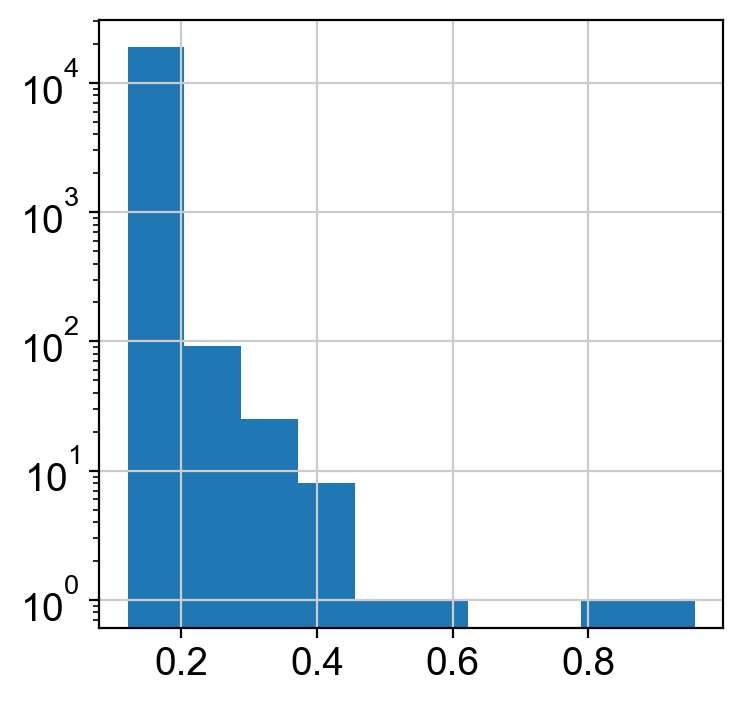

In [88]:
plt.hist(means['control'].values)
plt.yscale('log')

We can also repeat this for every latent space output to get latent feature specific importance distributions. This might be interesting to look at in the case in which one dimension of the latent space mostly captures a certain set of features.

In [93]:
slice_distr = pd.DataFrame(index=adata.var_names, columns=list(range(output_dim)))
for i in range(output_dim):
    attribution_map_slice = attribution_map_genes_3d[:, i, :]
    slice_distr.iloc[:, i] = attribution_map_slice.abs().mean(0).numpy()

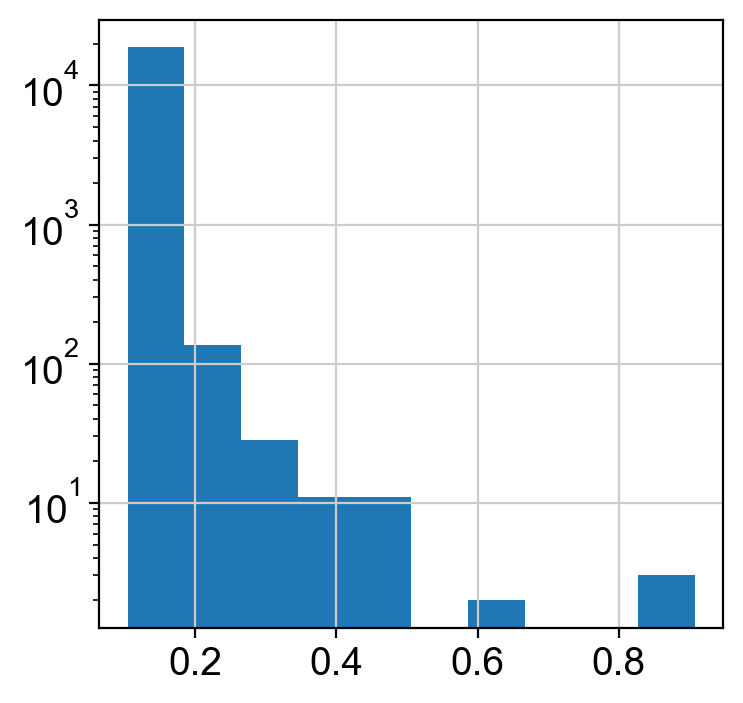

In [97]:
plt.hist(attribution_map_slice.abs().mean(0).numpy())
plt.yscale('log')

In [96]:
slice_distr.nlargest(100, 0)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
gene_symbols,,,,,,,,,,,,,,,,,,,,,
HBG2,0.740030,0.459080,0.230775,0.158995,0.283701,0.246451,0.544382,0.770927,0.453324,0.182565,...,0.266370,0.200625,0.847555,0.401495,0.832233,0.607670,0.171307,0.191102,0.259697,0.264651
TMSB4X,0.736228,0.332013,0.236403,0.130770,0.236082,0.221544,0.122239,0.382096,0.153705,0.182380,...,0.291760,0.285628,0.111880,0.210780,0.232772,0.301103,0.301667,0.319480,0.161783,0.348343
MALAT1,0.636165,0.398989,1.241278,2.049418,0.684960,0.522307,0.350814,0.762207,2.749656,0.773054,...,0.604424,1.320766,0.523088,1.196758,0.324893,1.497832,1.876721,0.493844,0.651570,0.307741
HBZ,0.586294,0.636979,0.305719,0.497456,0.677999,0.424693,0.887129,0.965333,0.499058,0.294380,...,0.300889,0.197030,1.345934,0.223367,0.600927,0.948743,0.166057,0.181631,0.302124,0.468891
RPS29,0.498702,0.288546,0.154511,0.280221,0.333327,0.171514,0.611554,0.599347,0.168893,0.282191,...,0.454070,0.583583,0.499825,0.195167,0.616918,0.233376,0.175680,0.171832,0.165230,0.500698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CLIC1,0.183696,0.152746,0.131453,0.121166,0.154819,0.164303,0.120697,0.184632,0.194969,0.141157,...,0.134684,0.162596,0.144329,0.126919,0.167127,0.102267,0.169711,0.223085,0.144268,0.174808
BID,0.182593,0.158146,0.135726,0.133263,0.122526,0.159668,0.118000,0.156906,0.119326,0.117217,...,0.130746,0.168987,0.131460,0.134548,0.116095,0.107414,0.106224,0.196450,0.160589,0.148335
USMG5,0.181945,0.209181,0.180189,0.117688,0.198574,0.206550,0.169001,0.213594,0.150381,0.125288,...,0.146069,0.233391,0.235964,0.203893,0.129025,0.239136,0.219620,0.187161,0.140431,0.189638


Check that they are anticorrelated as we would expect. Why do we not see any negative correlations..? Maybe it's because I only have control samples in here...

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


<AxesSubplot: >

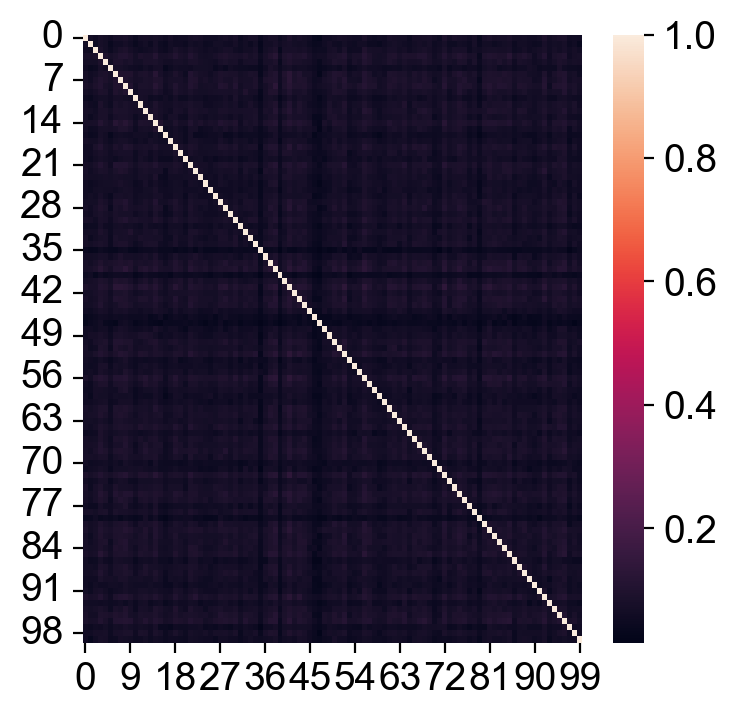

In [107]:
sns.heatmap(slice_distr.corr('spearman'))

Store results.

In [13]:
means.to_csv("../../outputs/ablation/task2_latent.csv")